<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

<div class="alert alert-block alert-warning">
<b>⚠️ Совет:</b>

Важно чтобы в проектах было подробное описание: когда потенциальные работодатели будут смотреть твой проект в портфолио, им нужно будет понимать задачу, чтобы можно было оценить её решение. Вот что можно добавить:
    
* Описание целей и задачи проекта
* Описание данных
* План работы

И рекомендую писать введение от первого лица множественного числа. Так работа выглядит более самостоятельной)
</div>

## Подготовка данных

In [ ]:
import pandas as pd

from sklearn.preprocessing import StandardScaler

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve

import matplotlib.pyplot as plt

from random import randint

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
data = pd.read_csv('/datasets/Churn.csv')
print(data.info())
print('*' * 50)
print(data.shape)
print('*' * 50)
print(data.head())
print('*' * 50)
print(data.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None
**************************************************
(10000, 14)
**************************

**Удалим ненужные стобцы и сделаем Onehot encoding**

In [ ]:
data = data.drop(['Surname', 'RowNumber', 'CustomerId'], axis=1)
data_ohe = pd.get_dummies(data, drop_first=True)

**Заменим пропуски в стобце Tenure на случайные числа от 0 до 10**

In [ ]:
data_ohe['Tenure'] = data_ohe['Tenure'].apply(lambda v: randint(0, 10))
data_ohe['Tenure'].unique()

array([ 6,  3,  0,  7,  8,  5,  9, 10,  1,  2,  4])

**Scaling**

In [ ]:
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

scaler = StandardScaler().fit(data_ohe[numeric])

data_ohe[numeric] = scaler.transform(data_ohe[numeric])

print(data_ohe.head())

   CreditScore       Age  Tenure   Balance  NumOfProducts  HasCrCard  \
0    -0.326221  0.293517       6 -1.225848              1          1   
1    -0.440036  0.198164       3  0.117350              1          0   
2    -1.536794  0.293517       6  1.333053              3          1   
3     0.501521  0.007457       0 -1.225848              2          0   
4     2.063884  0.388871       7  0.785728              1          1   

   IsActiveMember  EstimatedSalary  Exited  Geography_Germany  \
0               1         0.021886       1                  0   
1               1         0.216534       0                  0   
2               0         0.240687       1                  0   
3               0        -0.108918       0                  0   
4               1        -0.365276       0                  0   

   Geography_Spain  Gender_Male  
0                0            0  
1                1            0  
2                0            0  
3                0            0  
4     

**Деление на обучающую, валидационную и тестовую выборки**

In [ ]:
target = data_ohe['Exited']
features = data_ohe.drop('Exited', axis=1)
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.4, random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5, random_state=12345)



## Исследование задачи

**Logistic regression**

In [ ]:
logic_model = LogisticRegression(random_state=12345).fit(features_train, target_train)
predictions = logic_model.predict(features_valid)

probabilities_valid = logic_model.predict_proba(features_valid)
probabilities_one = probabilities_valid[:, 1]

print("Accuracy:", accuracy_score(predictions, target_valid))
print("F1:", f1_score(predictions, target_valid))
print("AUC-ROC:", roc_auc_score(target_valid, probabilities_one))

Accuracy: 0.801
F1: 0.3208191126279864
AUC-ROC: 0.7571513256189548


**Random Forest**

In [ ]:
forest_model = RandomForestClassifier().fit(features_train, target_train)
predictions = forest_model.predict(features_valid)

probabilities_valid = forest_model.predict_proba(features_valid)
probabilities_one = probabilities_valid[:, 1]

print("Accuracy:",  accuracy_score(predictions, target_valid))
print("F1:", f1_score(predictions, target_valid))
print("AUC-ROC:", roc_auc_score(target_valid, probabilities_one))

Accuracy: 0.8615
F1: 0.5834586466165413
AUC-ROC: 0.8322999776190274


*F1 у Random Forest выше, будем использовать его*

## Борьба с дисбалансом

**Upsampling**

0    7963
1    2037
Name: Exited, dtype: int64


Text(0.5, 1.0, 'Соотношение классов')

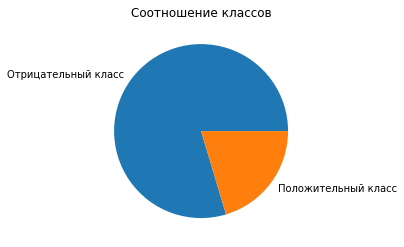

In [ ]:
print(data_ohe['Exited'].value_counts())
plt.pie(data_ohe['Exited'].value_counts(), labels=('Отрицательный класс', 'Положительный класс'))
plt.title("Соотношение классов")

*Выявлен явный дисбаланс классов, отрицательного к положительному - 4 к 1*

In [ ]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled


features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [ ]:
forest_model = RandomForestClassifier().fit(features_upsampled, target_upsampled)
predicted = forest_model.predict(features_valid)

probabilities_valid = forest_model.predict_proba(features_valid)
probabilities_one = probabilities_valid[:, 1]

print("F1:", f1_score(predicted, target_valid), "AUC-ROC:", roc_auc_score(target_valid, probabilities_one))


F1: 0.6074270557029178 AUC-ROC: 0.8359013483023731


**Downsampling**

In [ ]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.7)

In [ ]:
forest_model = RandomForestClassifier().fit(features_downsampled, target_downsampled)
predicted = forest_model.predict(features_valid)

probabilities_valid = forest_model.predict_proba(features_valid)
probabilities_one = probabilities_valid[:, 1]

print("F1:", f1_score(predicted, target_valid), "AUC-ROC:", roc_auc_score(target_valid, probabilities_one))

F1: 0.6202185792349726 AUC-ROC: 0.8349524253110652


*Методы выдают примерно одиниковый показатель F1, но для баланса в Downsampling пришлось удалить 70% датафрейма, что может сказаться в дальнейшем на качаство модели, поэтому выбираем Upsampling*

**Найдем лучший параметр глубины**

In [ ]:
best = 0
for depth in range(1, 30, 1):
    forest_model = RandomForestClassifier(max_depth=depth).fit(features_upsampled, target_upsampled)
    predicted = forest_model.predict(features_valid)

    probabilities_valid = forest_model.predict_proba(features_valid)
    probabilities_one = probabilities_valid[:, 1]
    if f1_score(predicted, target_valid) > best:
        print("F1:", f1_score(predicted, target_valid), "AUC-ROC:", roc_auc_score(target_valid, probabilities_one), "Depth:", depth)
        best = f1_score(predicted, target_valid)
print('Complete!')

F1: 0.5357483317445185 AUC-ROC: 0.801571507207278 Depth: 1
F1: 0.5692599620493358 AUC-ROC: 0.8146318632462088 Depth: 2
F1: 0.5867446393762183 AUC-ROC: 0.8315597420744137 Depth: 3
F1: 0.5884615384615385 AUC-ROC: 0.8373916488727854 Depth: 4
F1: 0.5932367149758453 AUC-ROC: 0.8479379260702037 Depth: 5
F1: 0.6045589692765113 AUC-ROC: 0.8523884127051338 Depth: 6
F1: 0.6222222222222222 AUC-ROC: 0.8545388007428064 Depth: 7
F1: 0.6262833675564682 AUC-ROC: 0.8557289240801117 Depth: 8
F1: 0.6278814489571899 AUC-ROC: 0.8514599047901331 Depth: 10
Complete!


*Мы получили F1 рывный 62% и AUC-ROC равный 85% при глубине 8, будем использоват эту глубину*

## Тестирование модели

In [ ]:
forest_model = RandomForestClassifier(max_depth=8).fit(features_upsampled, target_upsampled)
predicted = forest_model.predict(features_test)

probabilities_valid = forest_model.predict_proba(features_valid)
probabilities_one = probabilities_valid[:, 1]

In [ ]:
print("F1:", f1_score(predicted, target_test))
print("AUC-ROC:", roc_auc_score(target_valid, probabilities_one))

F1: 0.6107178968655207
AUC-ROC: 0.8568857784041762


**Визуализируем ROC-кривую лучшей модели.**

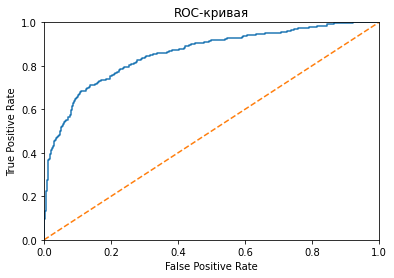

In [ ]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one)

plt.figure()

plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.title("ROC-кривая")
plt.show()

**Вывод:**
- Нами был проведен первичный анализ данных, выявлен явный дисбаланс классов, отрицательного к положительному - 4 к 1.
- Произвели предобработку данных, заполнили пропуски модой, прошкалировали количественные переменные, сделали Onehot encoding.
- Модель случайного леса до борьбы с дисбалансом показывала результат метрики f1 - 58%.
- Произвели upsampling положительного класса, благодаря чему удалось повысить f1 меру до 60%. Dowmsampling оказался более эффективен.
- Нашли лучший параметр глубины. благодаря чему удалось повысить f1 меру до 62%
- Проверка на тестовой выборке подтверждает, что upsampling помог справиться с дисбалансом классов и удалось увеличить метрику f1 до 61%.